In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

## Padding a 3D mesh

This notebook shows how to pad a 3D mesh.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(48, 120, 72)


<IPython.core.display.Javascript object>


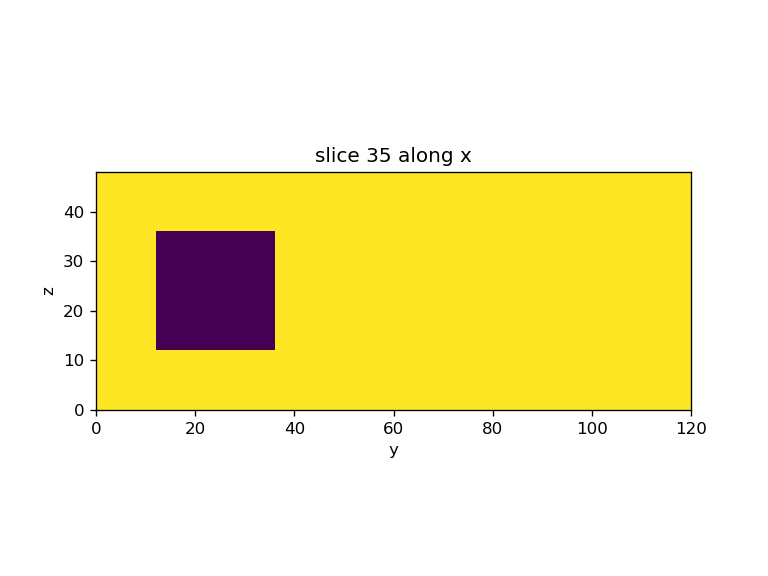

interactive(children=(IntSlider(value=35, description='index', max=71), RadioButtons(description='along', opti…

Generated contour with 14028 cells


In [2]:
import numpy as np
from nanomesh import Volume

n = 24
m = 12

data = np.ones([2*n, 5*n, 3*n], dtype=int)
data[m:3*m, m:3*m, 0:3*n] = 0

print(data.shape)

vol = Volume(data)
vol.show_slice()

# generate contours
from nanomesh.mesh3d import Mesher3D

mesher = Mesher3D(vol)
mesher.generate_contour()

contour = mesher.contour

### Padding a mesh

First step is to create a bounding box for the padded area (below).

In [3]:
from itertools import tee
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [4]:
import copy
from nanomesh.mesh_utils_3d import pad3d
from nanomesh.mesh3d import close_side, BoundingBox

pad_side = 'bottom'

contour2 = copy.copy(contour)

edge_col, edge_value, extra_coords = pad3d(contour2, side=pad_side, width=20, opts='-pAq1.2 -a100', label=3)

n_points = len(contour2.points)
points = np.vstack([contour2.points, extra_coords])

cols = {
    'top': (0,1,1,0),
    'bottom': (0,1,1,0),
    'left': (0,2,2,0),
    'right': (0,2,2,0),
    'front': (1,2,2,1),
    'back': (1,2,2,1),
}[pad_side]

new_triangles = [
    np.array((0,1,2)) + n_points, 
    np.array((3,1,2)) + n_points,
]

for corner, col in zip(extra_coords, cols):
    connect_to = np.argwhere(
        (points[:, edge_col] == edge_value) & 
        (points[:,col] == corner[col])
    )
    
    additional_points = np.argwhere(extra_coords[:,col] == corner[col]) + n_points
   
    first, last = additional_points    
    first_point = points[first]    

    sorted_by_distance = np.argsort(np.linalg.norm(first_point - points[connect_to].squeeze(), axis=1))
    connect_to = connect_to[sorted_by_distance]
    connect_to = np.vstack([connect_to, last]).squeeze()

    for pair in pairwise(connect_to):
        tri = np.hstack((first, pair))
        new_triangles.append(tri)

new_triangles = np.array(new_triangles).squeeze()

cells = np.vstack([contour2.cells, new_triangles])

from nanomesh.mesh_container import TriangleMesh
padded_mesh = TriangleMesh(points=points, cells=cells)

In [5]:
padded_mesh.plot_itk()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

### Generate tetrahedral mesh

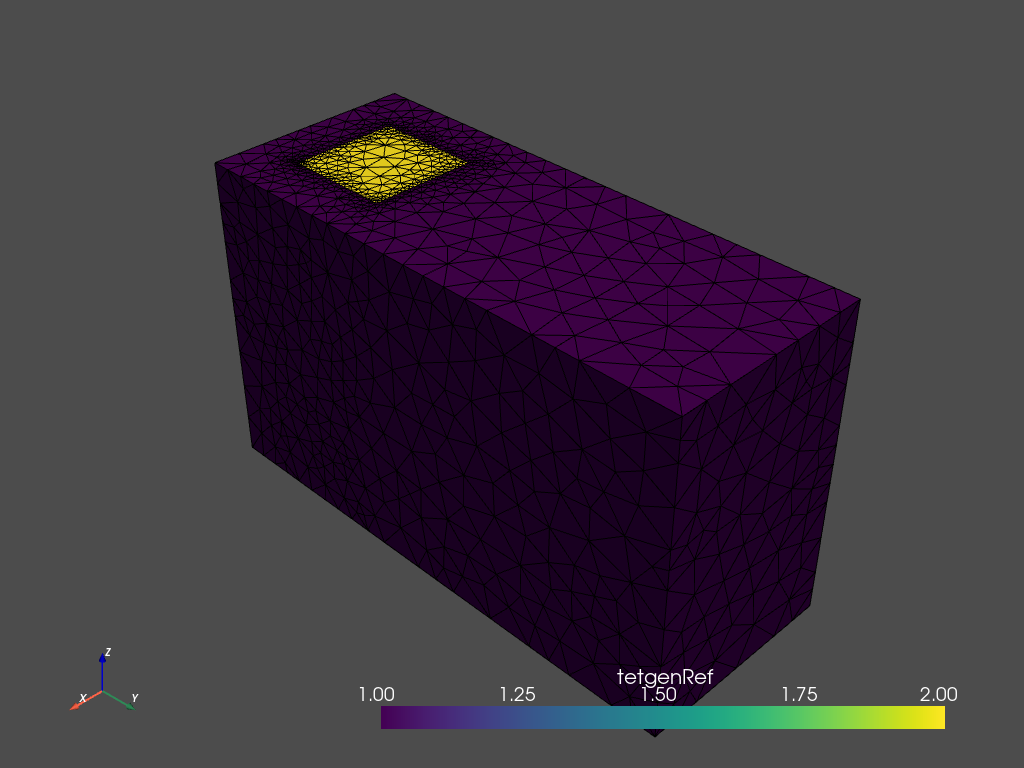

In [6]:
# tetramesh
tetras = mesher.tetrahedralize(opts='-pAq1.2 -a100')
tetras.metadata['labels'] = tetras.metadata['tetgenRef']
tetras.plot_pyvista(jupyter_backend='static', show_edges=True)  # Use .plot_itk() for an interactive view 